In [14]:
#creates connectivity matrix
import os
import sys
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import image, input_data, datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

run_num = 3
runs = list(range(1, run_num + 1))

# Define the number of ROIs for the Schaefer atlas
n_rois = 200

def verify_standard_space(img):
    """Verify image is in 2mm standard space"""
    if img.shape[:3] != (91, 109, 91):
        logging.warning(f"Unexpected shape: {img.shape}")
        return False
    
    vox_size = np.sqrt(np.sum(img.affine[:3, :3] ** 2, axis=0))
    if not np.allclose(vox_size, [2., 2., 2.], atol=0.1):
        logging.warning(f"Unexpected voxel size: {vox_size}")
        return False
    
    return True

def create_connectivity_matrix(ss):
    """Create connectivity matrix using standard space data"""
    logging.info(f"Processing subject: {ss}")
    
    # Load Schaefer atlas (already in MNI 2mm space)
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=n_rois, yeo_networks=7, resolution_mm=2)
    atlas_img = atlas.maps
    
    all_runs_data = []
    
    for rn in runs:
        # Load standard space data
        run_path = f'{raw_dir}/{ss}/ses-01/derivatives/reg_standard/filtered_func_run-0{rn}_standard.nii.gz' # corrected standard space path
        
        if not os.path.exists(run_path):
            logging.warning(f'Standard space data not found: {run_path}')
            continue
        
        subject_img = nib.load(run_path)
        
        # Verify standard space
        if not verify_standard_space(subject_img):
            logging.warning(f"Data not in expected standard space for {ss} run-{rn}")
            continue
        
        # Extract time series using the atlas
        masker = NiftiLabelsMasker(
            labels_img=atlas_img,
            standardize=True,
            memory='nilearn_cache',
            verbose=0
        )
        
        time_series = masker.fit_transform(subject_img)
        all_runs_data.append(time_series)
    
    if not all_runs_data:
        logging.warning(f'No valid run data found for subject {ss}')
        return None
    
    # Concatenate runs
    full_time_series = np.concatenate(all_runs_data, axis=0)
    
    # Compute connectivity matrix
    correlation_measure = ConnectivityMeasure(kind='correlation')
    connectivity_matrix = correlation_measure.fit_transform([full_time_series])[0]
    
    return connectivity_matrix

def main():
    for ss in subs:
        connectivity_matrix = create_connectivity_matrix(ss)
        if connectivity_matrix is not None:
            # Save with modified filename to indicate standard space
            output_dir = f'{results_dir}/connectivity_matrices_{n_rois}_standard'
            os.makedirs(output_dir, exist_ok=True)
            np.save(f'{output_dir}/{ss}_connectivity_matrix_standard.npy', connectivity_matrix)
            logging.info(f'Saved standard space connectivity matrix for {ss}')

if __name__ == "__main__":
    main()

2024-11-15 15:25:05,445 - INFO - Processing subject: sub-025


/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/maskers/nifti_labels_masker.py:614: UserWarning: Persisting input arguments took 0.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix


Summary Statistics:
       mean_correlation  std_deviation  min_correlation  max_correlation
count         19.000000      19.000000        19.000000             19.0
mean           0.361798       0.187693        -0.339529              1.0
std            0.095972       0.017685         0.117522              0.0
min            0.152873       0.154212        -0.623154              1.0
25%            0.307859       0.178138        -0.367369              1.0
50%            0.354549       0.183083        -0.341847              1.0
75%            0.421022       0.195960        -0.282128              1.0
max            0.536153       0.231258        -0.097116              1.0


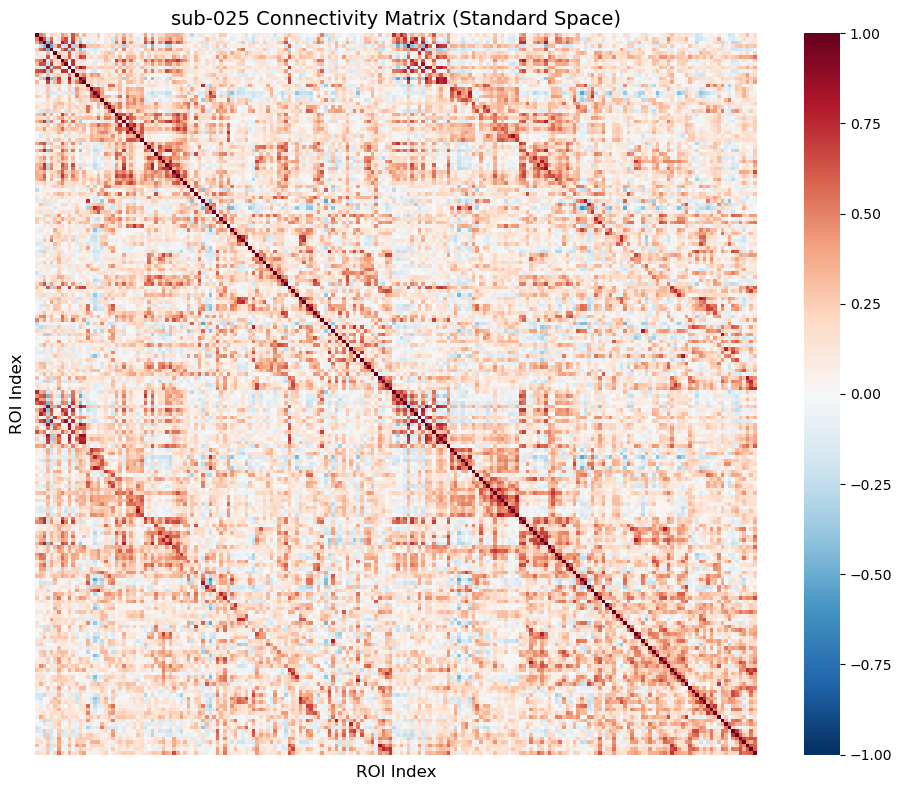

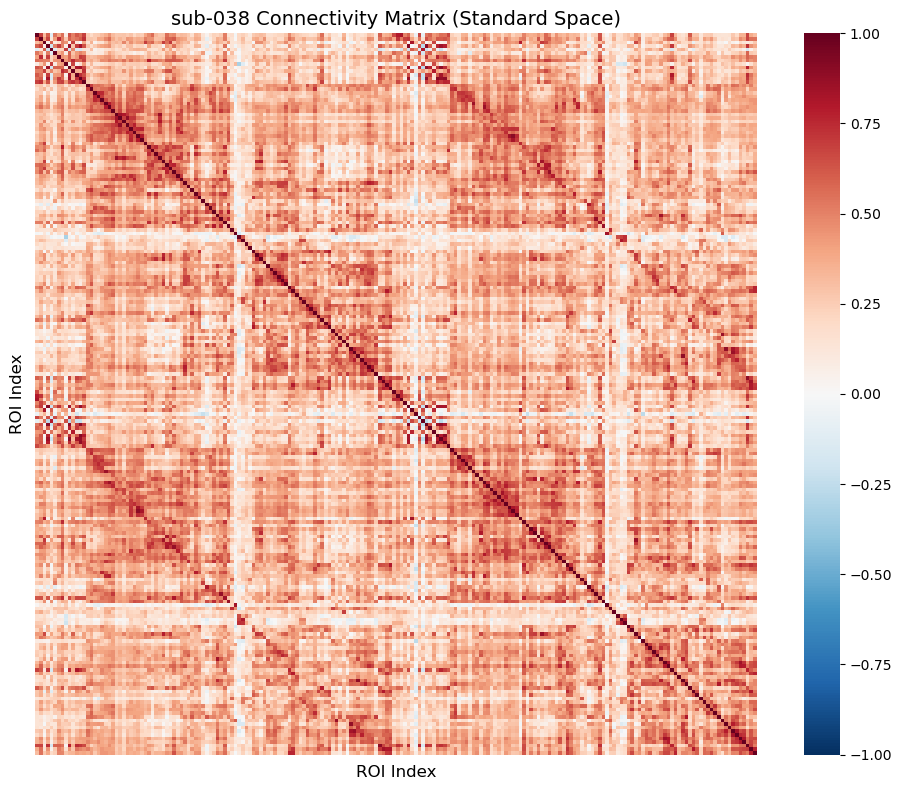

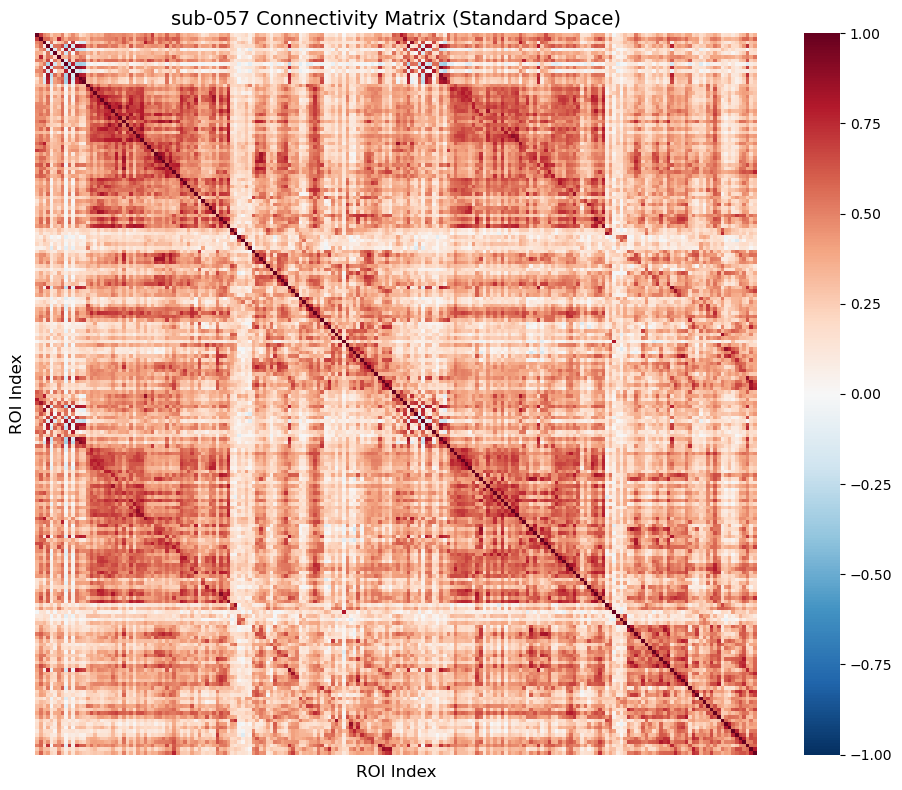

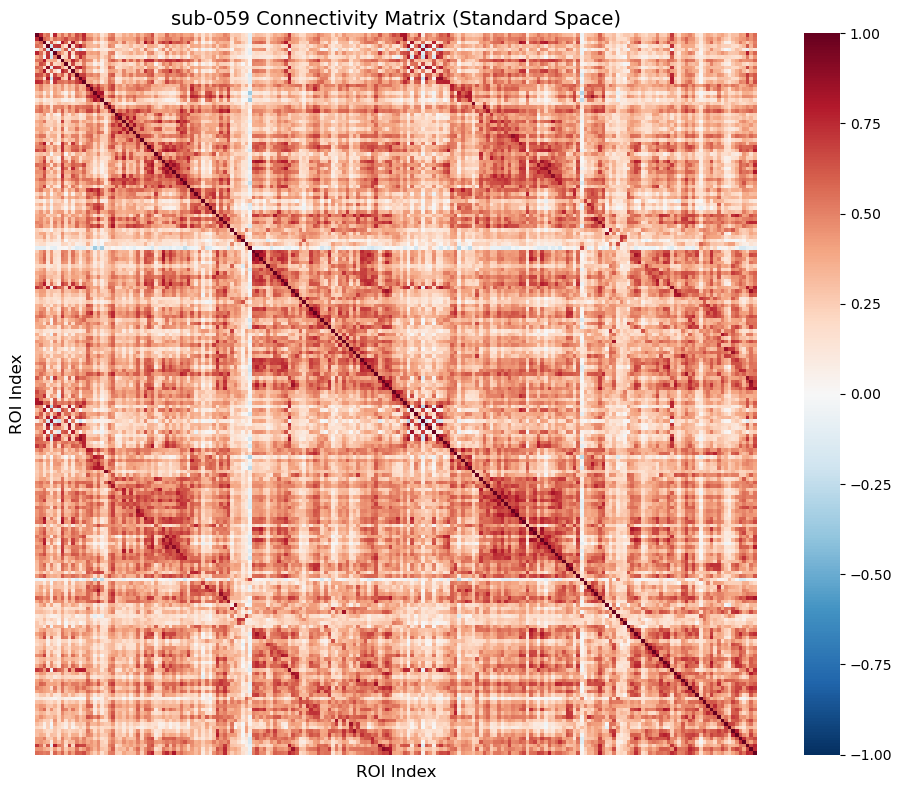

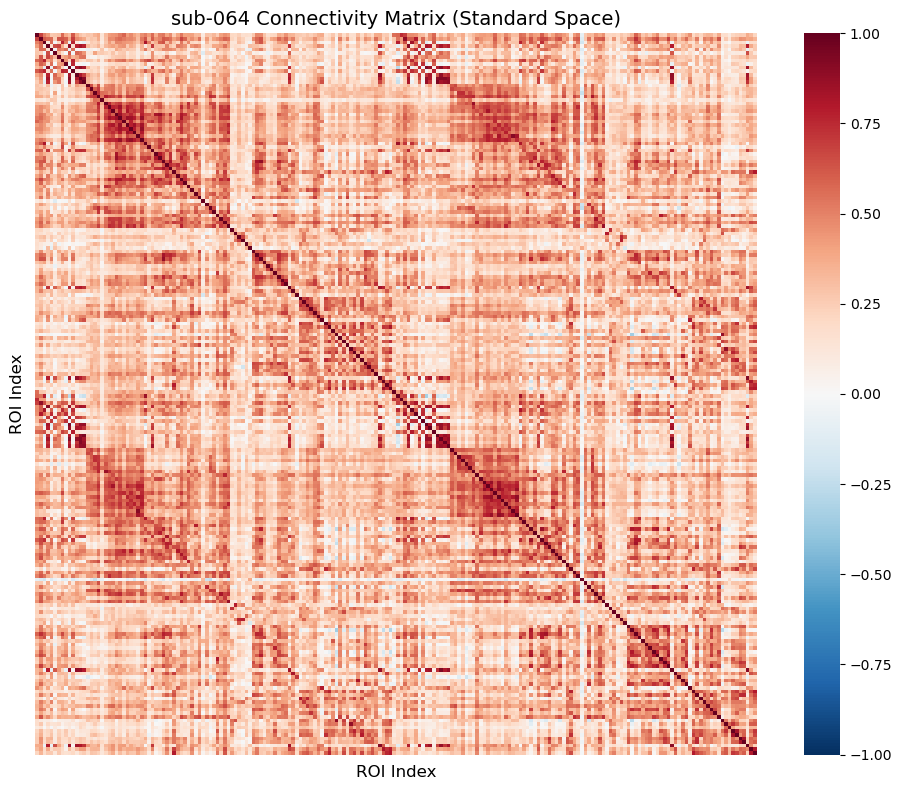

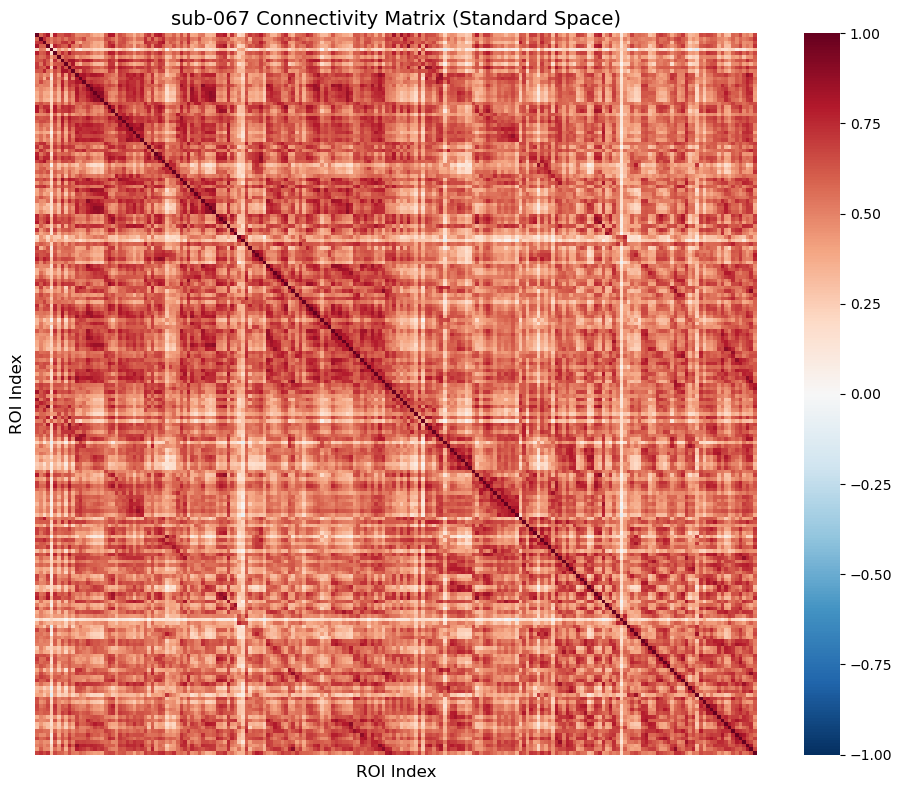

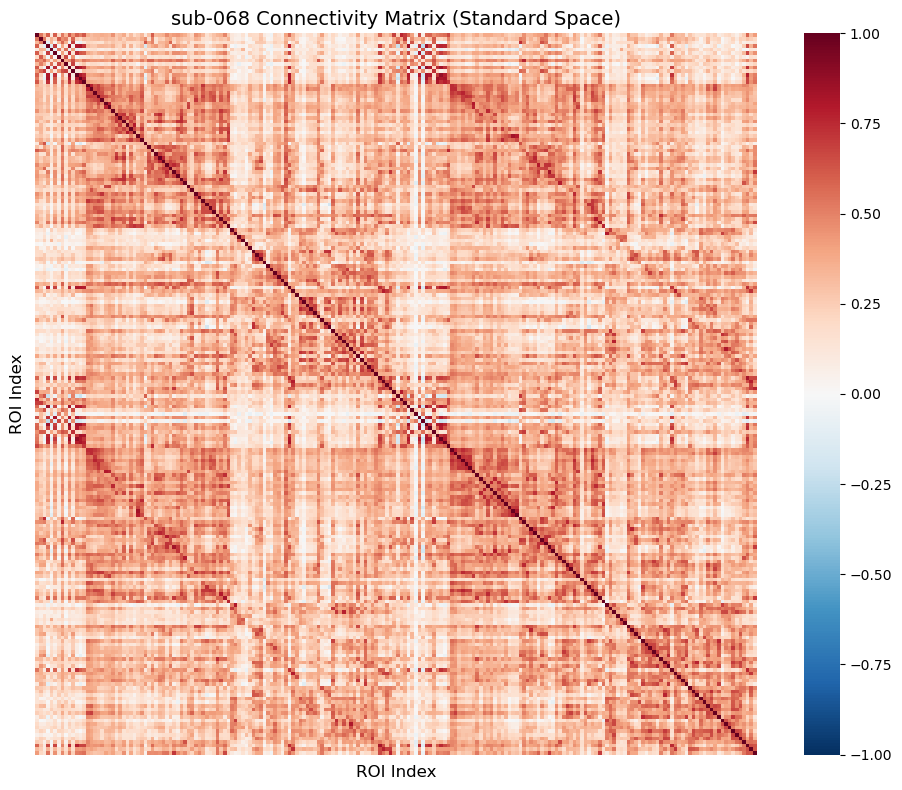

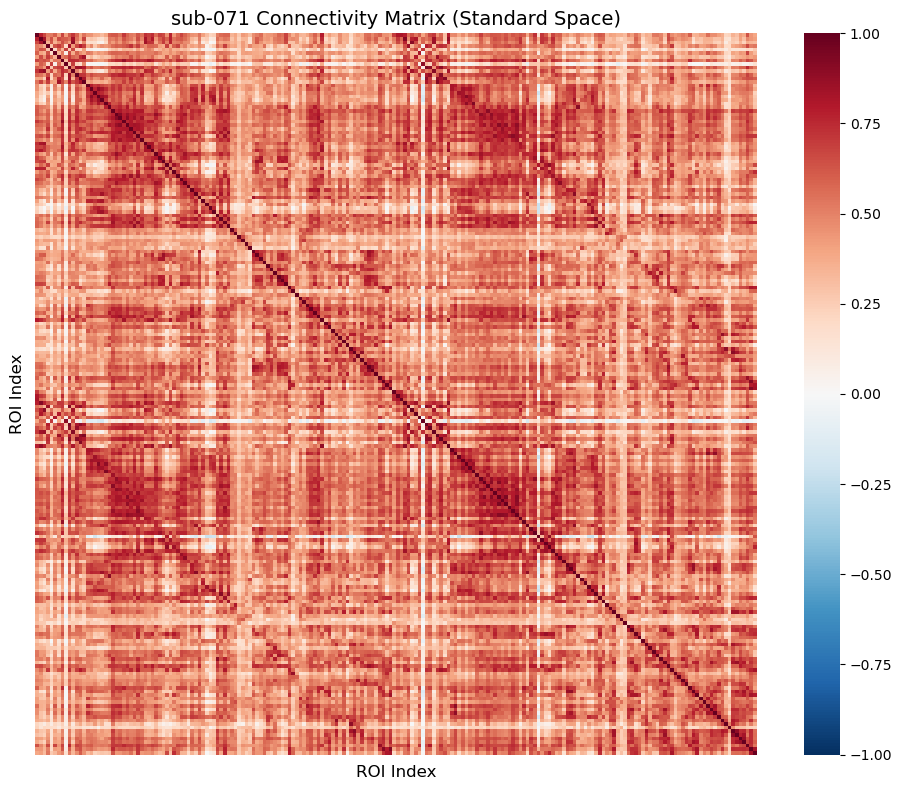

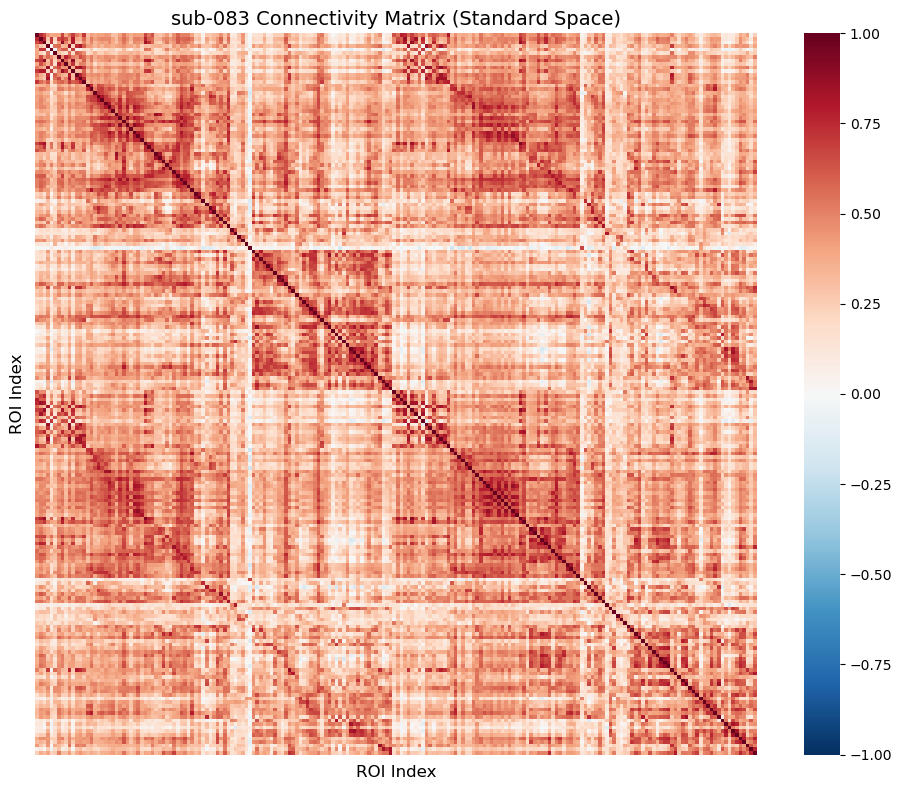

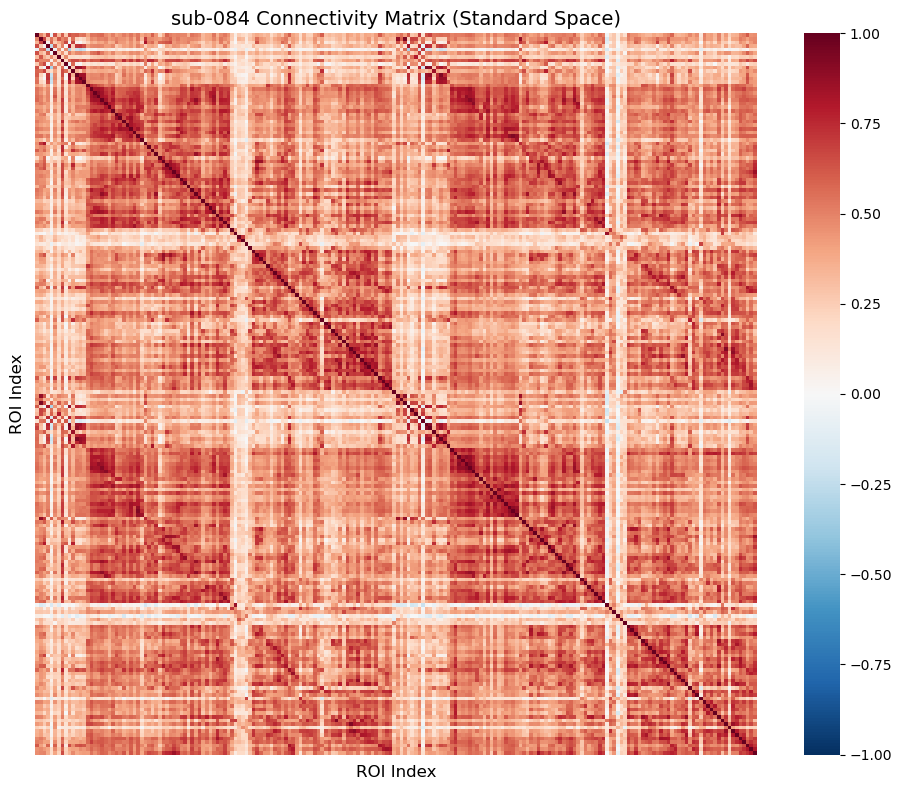

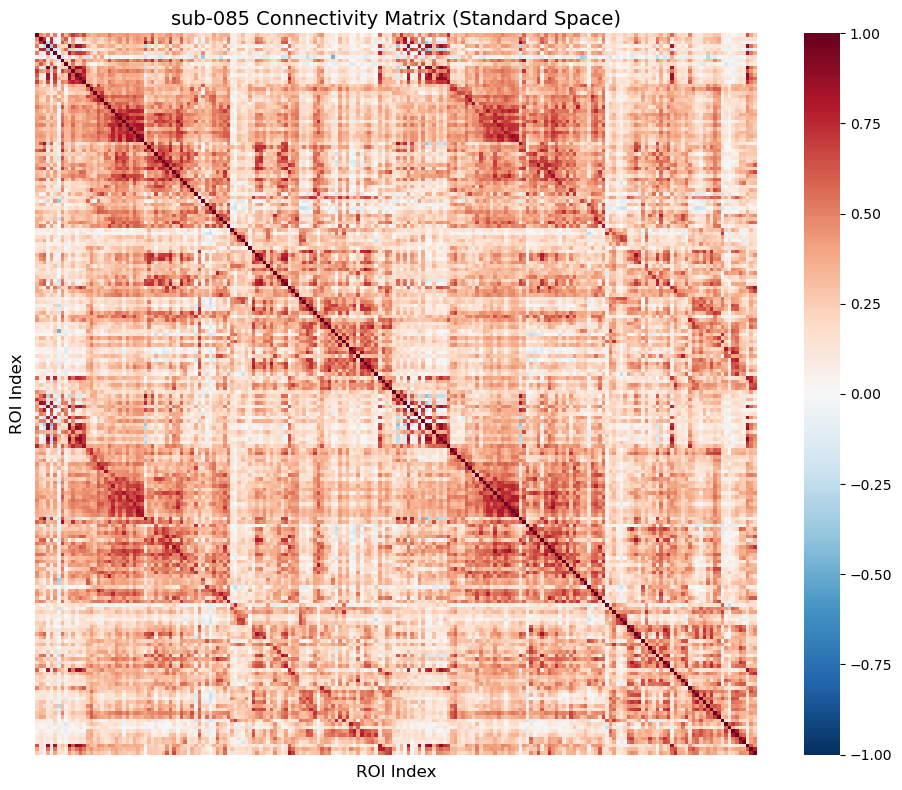

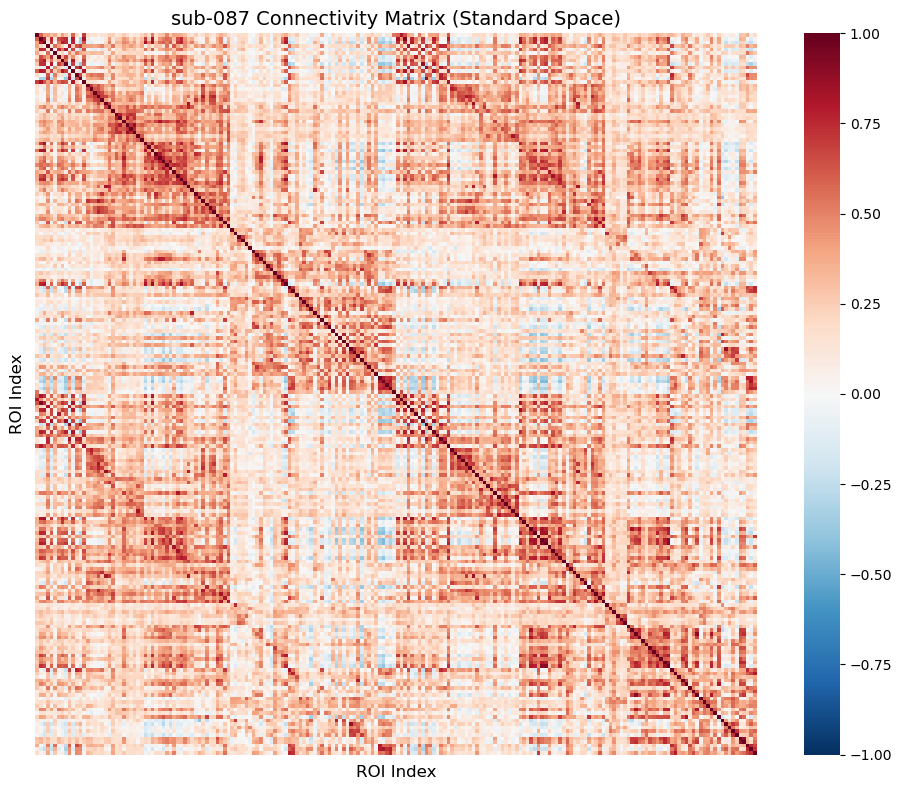

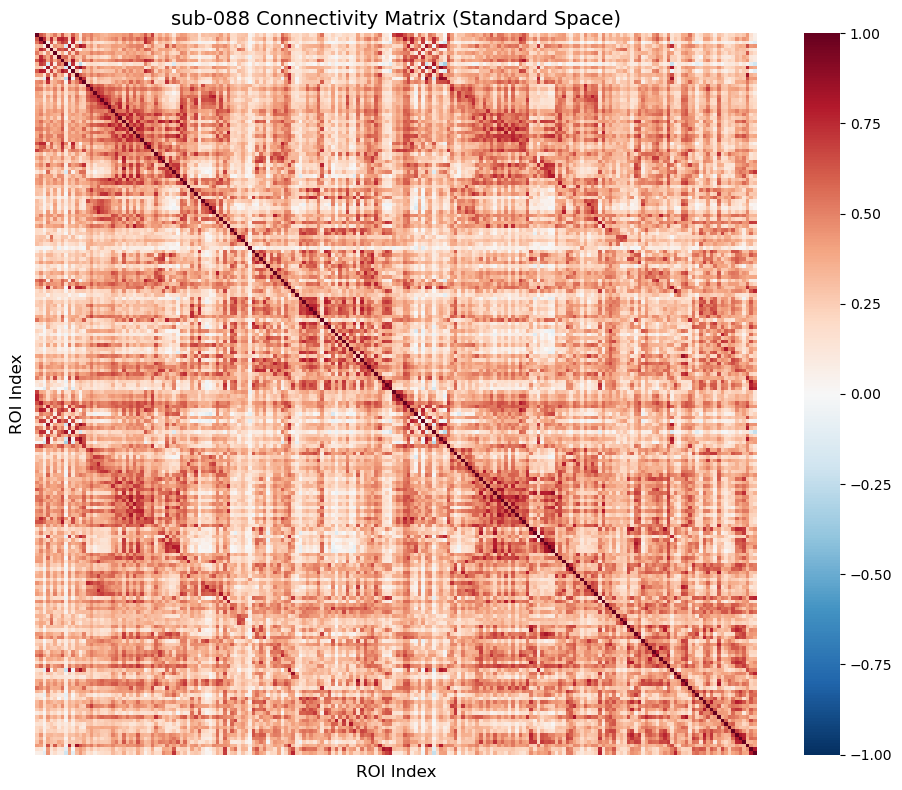

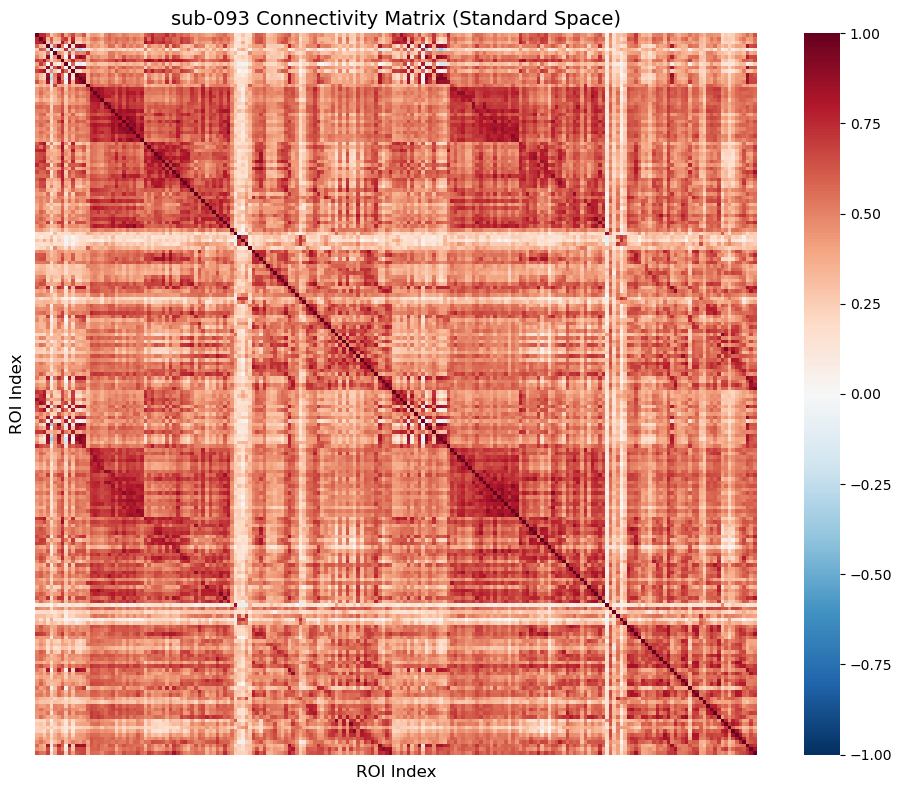

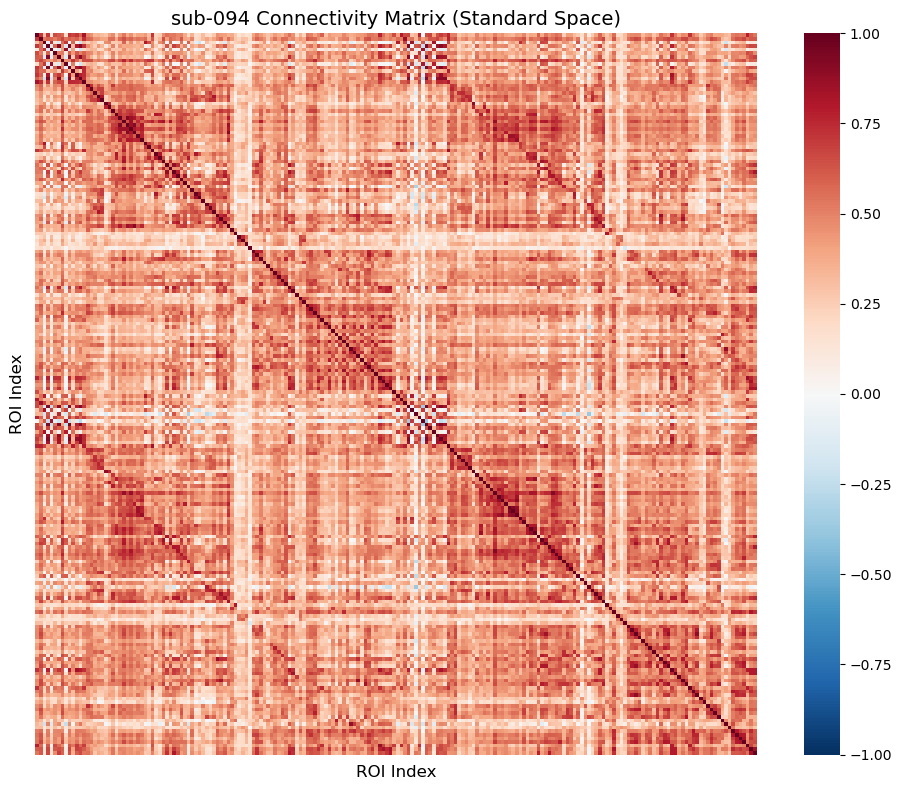

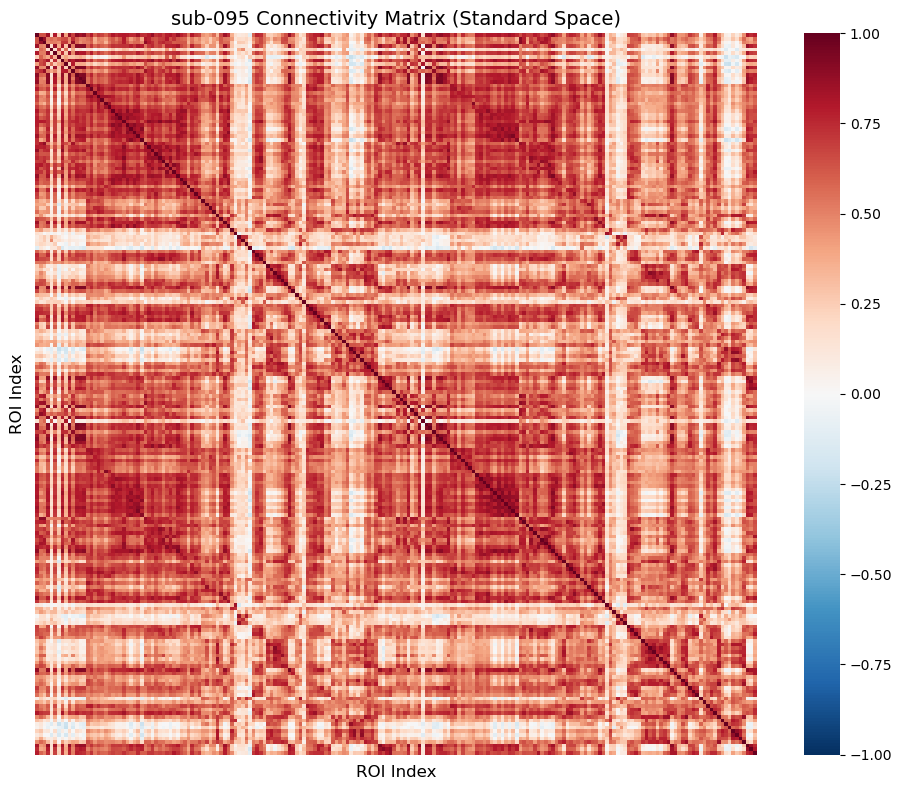

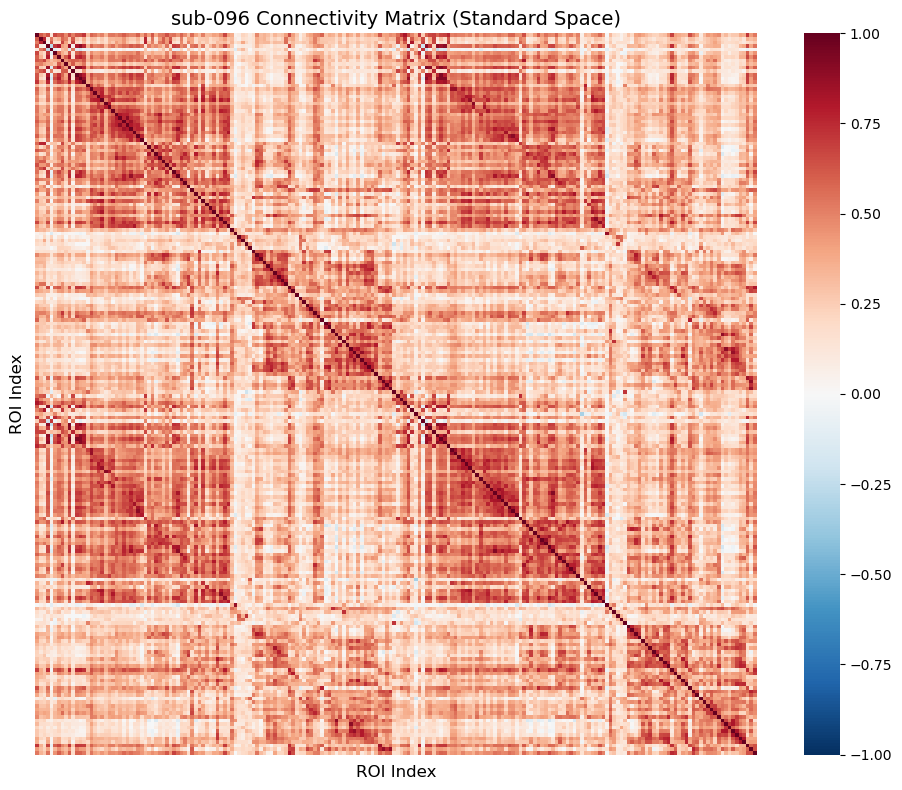

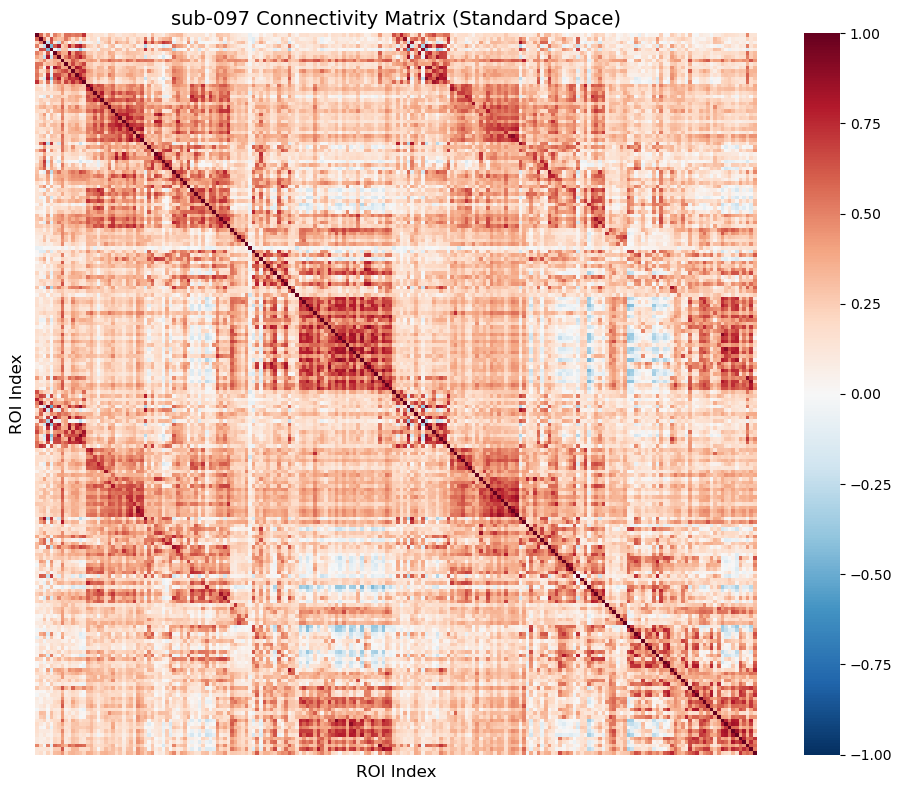

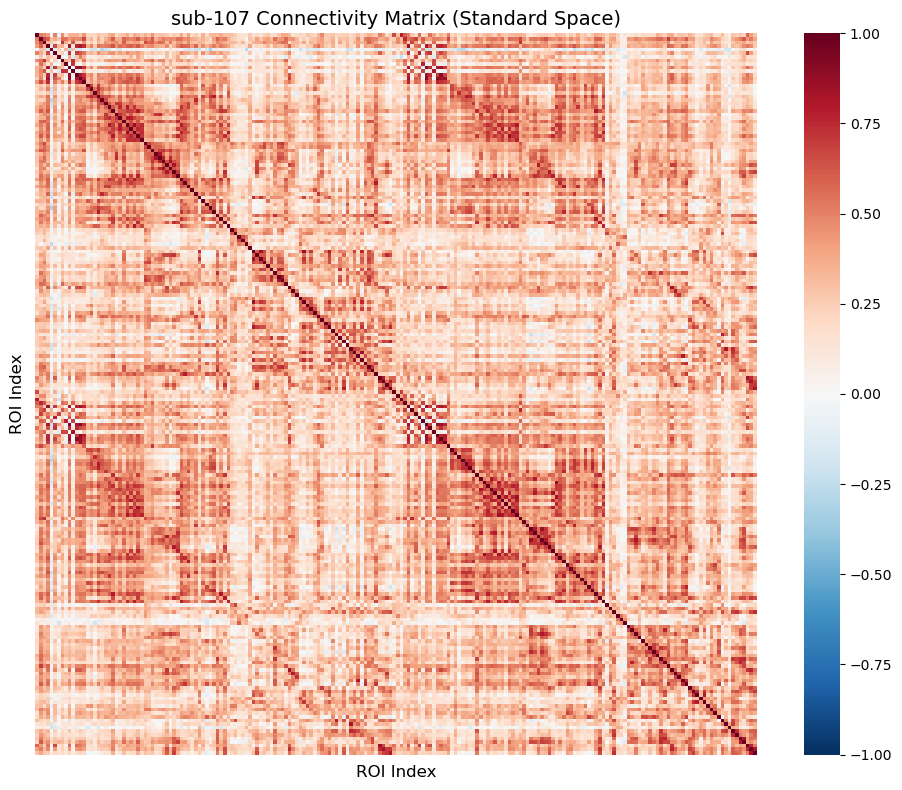

In [15]:
# create connectivity matrices for all subjects
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import os

# Create output directory if it doesn't exist
output_dir = 'figures'
os.makedirs(output_dir, exist_ok=True)

# Load subject information
curr_dir = "."  # Adjust if needed
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & 
                (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

# Initialize lists to store statistics
all_stats = []

# Process each subject
for sub in subs:
    try:
        # Load the connectivity matrix
        matrix_path = f'{curr_dir}/results/connectivity_matrices_200_standard/{sub}_connectivity_matrix_standard.npy'
        conn_matrix = np.load(matrix_path)
        
        # Calculate statistics
        stats = {
            'subject': sub,
            'mean_correlation': np.mean(conn_matrix),
            'std_deviation': np.std(conn_matrix),
            'min_correlation': np.min(conn_matrix),
            'max_correlation': np.max(conn_matrix)
        }
        all_stats.append(stats)
        
        # Create visualization
        plt.figure(figsize=(10, 8))
        
        # Create heatmap
        sns.heatmap(conn_matrix, 
                   cmap='RdBu_r',
                   center=0,
                   vmin=-1,
                   vmax=1,
                   square=True,
                   xticklabels=False,
                   yticklabels=False)
        
        # Add title and labels
        plt.title(f'{sub} Connectivity Matrix (Standard Space)', fontsize=14)
        plt.xlabel('ROI Index', fontsize=12)
        plt.ylabel('ROI Index', fontsize=12)
        
        # Adjust layout
        plt.tight_layout()
        
        # Save plot
        plt.savefig(f'{output_dir}/{sub}_connectivity_matrix.png', dpi=300, bbox_inches='tight')
        #plt.close()
        
    except Exception as e:
        print(f"Error processing subject {sub}: {str(e)}")
        continue

# Convert statistics to DataFrame
stats_df = pd.DataFrame(all_stats)

# Save statistics
stats_df.to_csv(f'{output_dir}/connectivity_statistics.csv', index=False)

# Create summary visualizations
plt.figure(figsize=(12, 6))

# Plot distribution of mean correlations
plt.subplot(121)
sns.histplot(stats_df['mean_correlation'], kde=True)
plt.title('Distribution of Mean Correlations')
plt.xlabel('Mean Correlation')

# Plot distribution of standard deviations
plt.subplot(122)
sns.histplot(stats_df['std_deviation'], kde=True)
plt.title('Distribution of Standard Deviations')
plt.xlabel('Standard Deviation')

plt.tight_layout()
plt.savefig(f'{output_dir}/summary_statistics.png', dpi=300, bbox_inches='tight')
plt.close()

# Display summary statistics
print("\nSummary Statistics:")
print(stats_df.describe())

In [16]:
# Check for NaN values
print("NaN values:", np.isnan(conn_matrix).any())

# Check symmetry
is_symmetric = np.allclose(conn_matrix, conn_matrix.T)
print("Matrix is symmetric:", is_symmetric)

# Check diagonal values
diagonal_ones = np.allclose(np.diag(conn_matrix), 1.0)
print("Diagonal values are 1:", diagonal_ones)

# Check value range
in_range = ((conn_matrix >= -1.0) & (conn_matrix <= 1.0)).all()
print("All values between -1 and 1:", in_range)

# Count strong connections
strong_connections = np.sum(np.abs(conn_matrix) > 0.5) / 2  # Divide by 2 due to symmetry
print(f"Number of strong connections (|r| > 0.5): {strong_connections}")

NaN values: False
Matrix is symmetric: True
Diagonal values are 1: True
All values between -1 and 1: True
Number of strong connections (|r| > 0.5): 2762.0


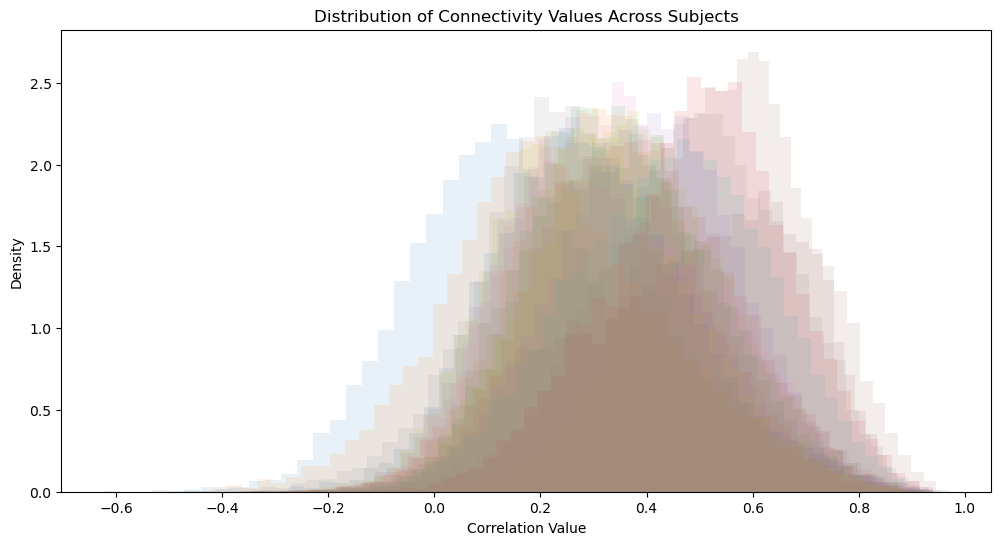

In [18]:
# Plot distribution of connectivity values for each subject
plt.figure(figsize=(12, 6))
for sub in subs:
    matrix = np.load(f'{curr_dir}/results/connectivity_matrices_200_standard/{sub}_connectivity_matrix_standard.npy')
    plt.hist(matrix[np.tril_indices_from(matrix, k=-1)], 
             bins=50, alpha=0.1, density=True)
plt.title('Distribution of Connectivity Values Across Subjects')
plt.xlabel('Correlation Value')
plt.ylabel('Density')
plt.show()

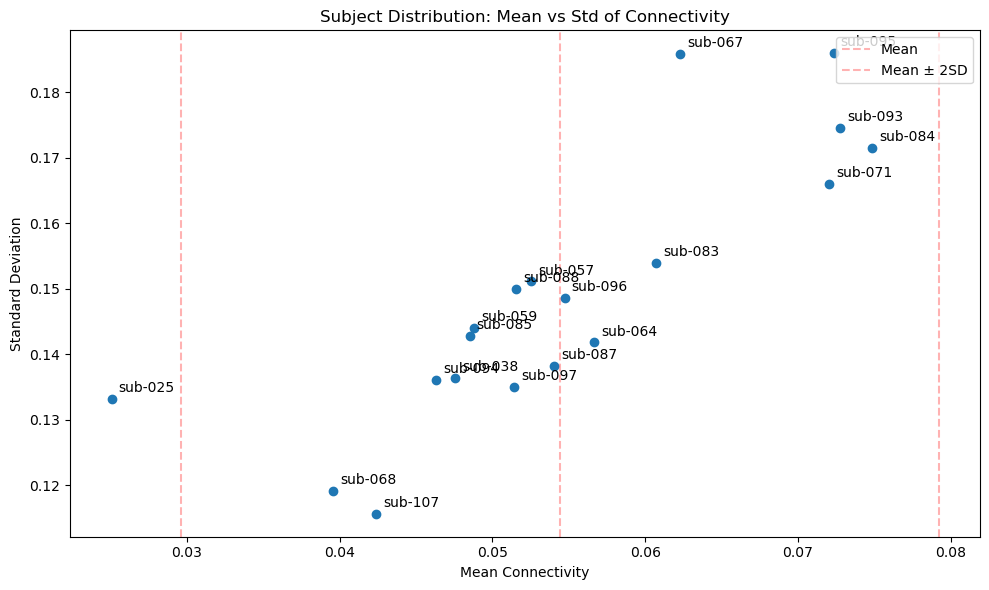

In [15]:
# Create scatter plot of mean vs std for each subject
plt.figure(figsize=(10, 6))

# Calculate means and stds for each subject
means = []
stds = []
for sub in subs:
    matrix = np.load(f'{curr_dir}/results/connectivity_matrices_200_standard/{sub}_connectivity_matrix_standard.npy')
    # Calculate using lower triangle of matrix (excluding diagonal)
    lower_triangle = matrix[np.tril_indices_from(matrix, k=-1)]
    means.append(np.mean(lower_triangle))
    stds.append(np.std(lower_triangle))

plt.scatter(means, stds)
for i, sub in enumerate(subs):
    plt.annotate(f'{sub}', (means[i], stds[i]), xytext=(5, 5), textcoords='offset points')

plt.xlabel('Mean Connectivity')
plt.ylabel('Standard Deviation')
plt.title('Subject Distribution: Mean vs Std of Connectivity')

# Add reference lines for mean ± 2SD
mean_of_means = np.mean(means)
std_of_means = np.std(means)
plt.axvline(mean_of_means, color='r', linestyle='--', alpha=0.3, label='Mean')
plt.axvline(mean_of_means + 2*std_of_means, color='r', linestyle='--', alpha=0.3, label='Mean ± 2SD')
plt.axvline(mean_of_means - 2*std_of_means, color='r', linestyle='--', alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()

2024-11-15 15:45:52,016 - INFO - Loaded matrix for subject sub-025
2024-11-15 15:45:52,018 - INFO - Loaded matrix for subject sub-038
2024-11-15 15:45:52,020 - INFO - Loaded matrix for subject sub-057


2024-11-15 15:45:52,022 - INFO - Loaded matrix for subject sub-059
2024-11-15 15:45:52,024 - INFO - Loaded matrix for subject sub-064
2024-11-15 15:45:52,026 - INFO - Loaded matrix for subject sub-067
2024-11-15 15:45:52,027 - INFO - Loaded matrix for subject sub-068
2024-11-15 15:45:52,029 - INFO - Loaded matrix for subject sub-071
2024-11-15 15:45:52,030 - INFO - Loaded matrix for subject sub-083
2024-11-15 15:45:52,032 - INFO - Loaded matrix for subject sub-084
2024-11-15 15:45:52,033 - INFO - Loaded matrix for subject sub-085
2024-11-15 15:45:52,034 - INFO - Loaded matrix for subject sub-087
2024-11-15 15:45:52,036 - INFO - Loaded matrix for subject sub-088
2024-11-15 15:45:52,037 - INFO - Loaded matrix for subject sub-093
2024-11-15 15:45:52,038 - INFO - Loaded matrix for subject sub-094
2024-11-15 15:45:52,040 - INFO - Loaded matrix for subject sub-095
2024-11-15 15:45:52,041 - INFO - Loaded matrix for subject sub-096
2024-11-15 15:45:52,043 - INFO - Loaded matrix for subject sub

Loaded matrices


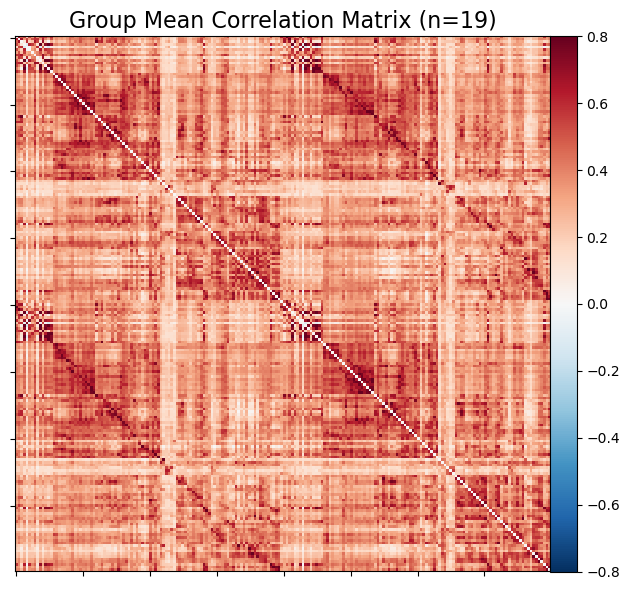

<Figure size 800x600 with 0 Axes>

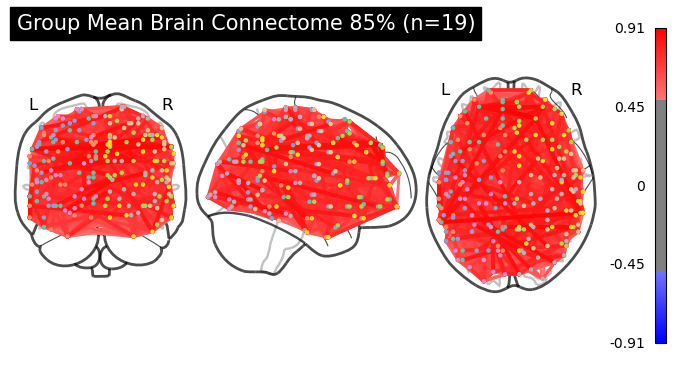

<Figure size 800x600 with 0 Axes>

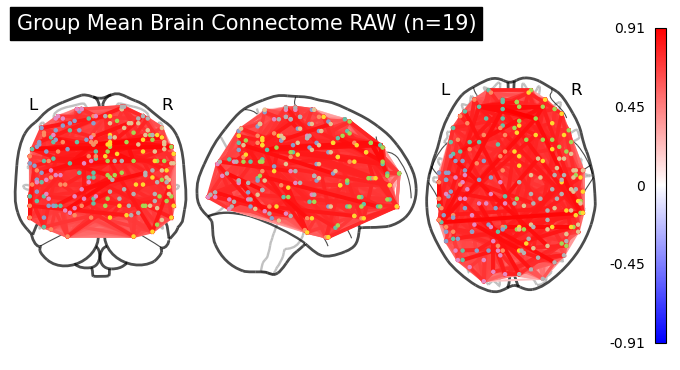


Group-Level Connectivity Statistics:
Number of subjects: 19
Shape: (200, 200)
Value range: [-0.138, 1.000]
Number of regions: 200


In [21]:
# plot connectome and visuals for group level
import os
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt
import pandas as pd
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load subject information
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

# Set up directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load coordinates
coords_path = 'analyses/network/200Parcels_Yeo2011_7Networks_FSLMNI152_2mm.csv'
coords_df = pd.read_csv(coords_path)
coords = coords_df[['R', 'A', 'S']].values

def load_all_matrices():
    """Load and average matrices across all subjects"""
    all_matrices = []
    
    for sub in subs:
        matrix_path = f'results/connectivity_matrices_200_standard/{sub}_connectivity_matrix_standard.npy'
        if os.path.exists(matrix_path):
            try:
                matrix = np.load(matrix_path)
                all_matrices.append(matrix)
                logging.info(f"Loaded matrix for subject {sub}")
            except Exception as e:
                logging.error(f"Error loading matrix for {sub}: {str(e)}")
    
    if not all_matrices:
        raise ValueError("No matrices were successfully loaded")
    
    print("Loaded matrices")
    
    # Calculate mean and standard deviation across subjects
    mean_matrix = np.mean(all_matrices, axis=0)
    std_matrix = np.std(all_matrices, axis=0)
    
    return mean_matrix, std_matrix, len(all_matrices)

def create_group_visualizations(mean_matrix, std_matrix, n_subjects):
    """Create group-level visualizations"""
    # Plot 1: Correlation Matrix
    fig = plt.figure(figsize=(15, 6))
    
    ax1 = plt.subplot(121)
    matrix_plot = mean_matrix.copy()
    np.fill_diagonal(matrix_plot, 0)
    
    plotting.plot_matrix(
        matrix_plot,
        colorbar=True,
        vmax=0.8,
        vmin=-0.8,
        title=f'Group Mean Correlation Matrix (n={n_subjects})',
        axes=ax1
    )
    
    # Plot 2.1: Brain Connectome as separate figure
    fig_connectome = plt.figure(figsize=(8, 6))
    display = plotting.plot_connectome(
        mean_matrix,
        coords,
        edge_threshold="85%",
        node_size=5,
        node_color='auto',
        colorbar=True,
        title=f'Group Mean Brain Connectome 85% (n={n_subjects})',
        display_mode='ortho'
    )
    
    # Plot 2.2: Brain Connectome as separate figure - RAW
    fig_connectome = plt.figure(figsize=(8, 6))
    display = plotting.plot_connectome(
        mean_matrix,
        coords,
        edge_threshold="0%",
        node_size=5,
        node_color='auto',
        colorbar=True,
        title=f'Group Mean Brain Connectome RAW (n={n_subjects})',
        display_mode='ortho'
    )
    
    # Show both plots
    plt.show()
    
    # Create interactive 3D view
    view = plotting.view_connectome(
        mean_matrix,
        coords,
        edge_threshold="0%"
    )
    
    # Print connectivity statistics
    print("\nGroup-Level Connectivity Statistics:")
    print(f"Number of subjects: {n_subjects}")
    print(f"Shape: {mean_matrix.shape}")
    print(f"Value range: [{mean_matrix.min():.3f}, {mean_matrix.max():.3f}]")
    print(f"Number of regions: {len(coords)}")

def main():
    try:
        # Load and average all matrices
        mean_matrix, std_matrix, n_subjects = load_all_matrices()
        
        # Create group-level visualizations
        create_group_visualizations(mean_matrix, std_matrix, n_subjects)
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()

Original dimensions:
MSDL: (40, 48, 35, 39)
MSDL affine:
[[   4.    0.    0.  -78.]
 [   0.    4.    0. -111.]
 [   0.    0.    4.  -51.]
 [   0.    0.    0.    1.]]
Schaefer: (91, 109, 91)
Schaefer affine:
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
Func: (91, 109, 91, 184)
Func affine:
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]


/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:67: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  "Given img is empty. "
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:439: UserWarning: empty mask
  new_img_like(img, not_mask, affine)
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/numpy/ma/core.py:2795: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Region Coverage Statistics:
Mean coverage: 0.999
Min coverage: 0.913
Number of regions with <50% coverage: 0


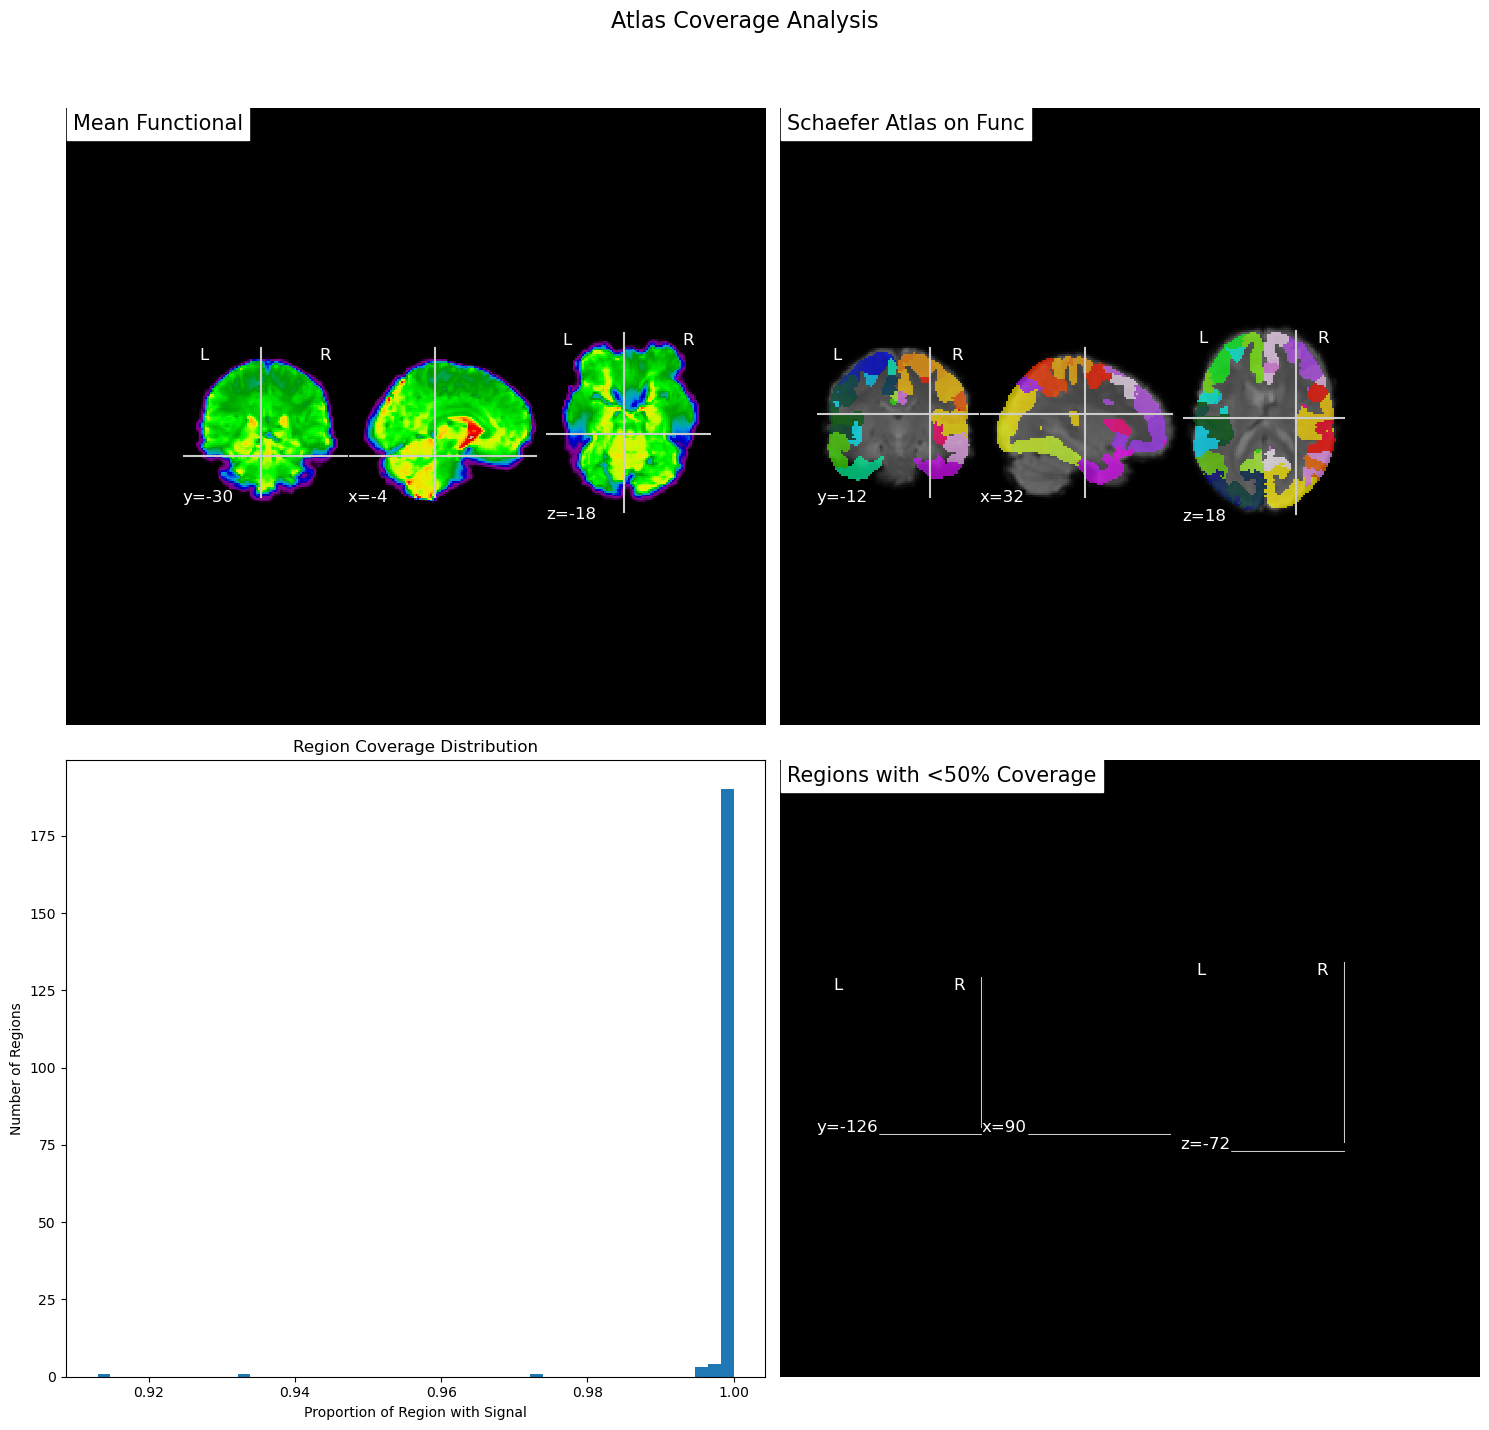

In [ ]:
# plot check
import os
import numpy as np
import nibabel as nib
from nilearn import datasets, plotting, image
import matplotlib.pyplot as plt
import ptoc_params as params

def check_atlases_and_data():
    # Load atlases
    msdl = datasets.fetch_atlas_msdl()
    schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200, resolution_mm=2)  # Changed to 2mm
    
    # Load atlas images
    msdl_img = nib.load(msdl.maps)
    schaefer_img = nib.load(schaefer['maps'])
    
    # Load example functional data
    sub = 'sub-025'
    run = 1
    func_path = f'{params.raw_dir}/{sub}/ses-01/derivatives/reg_standard/filtered_func_run-0{run}_standard.nii.gz'
    func_img = nib.load(func_path)
    mean_func = image.mean_img(func_img)
    
    # Print basic info and shapes
    print("Original dimensions:")
    print(f"MSDL: {msdl_img.shape}")
    print(f"MSDL affine:\n{msdl_img.affine}")
    print(f"Schaefer: {schaefer_img.shape}")
    print(f"Schaefer affine:\n{schaefer_img.affine}")
    print(f"Func: {func_img.shape}")
    print(f"Func affine:\n{func_img.affine}")
    
    # Create visualization figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle('Atlas Coverage Analysis', fontsize=16)
    
    # Plot mean functional
    plotting.plot_epi(mean_func, axes=axes[0,0], title='Mean Functional')
    
    # Plot Schaefer atlas
    plotting.plot_roi(schaefer_img, mean_func, axes=axes[0,1], 
                     title='Schaefer Atlas on Func')
    
    # Analyze coverage
    schaefer_data = schaefer_img.get_fdata()
    func_data = mean_func.get_fdata()
    
    region_counts = []
    signal_counts = []
    
    for i in range(1, 201):  # Schaefer has 200 regions
        region_mask = schaefer_data == i
        region_voxels = np.sum(region_mask)
        signal_voxels = np.sum((func_data[region_mask] != 0))
        region_counts.append(region_voxels)
        signal_counts.append(signal_voxels)
    
    coverage = np.array(signal_counts) / np.array(region_counts)
    
    # Plot the coverage distribution
    axes[1,0].hist(coverage, bins=50)
    axes[1,0].set_title('Region Coverage Distribution')
    axes[1,0].set_xlabel('Proportion of Region with Signal')
    axes[1,0].set_ylabel('Number of Regions')
    
    # Plot regions with low coverage
    masked_schaefer = np.zeros_like(schaefer_data)
    for i in range(200):
        if coverage[i] < 0.5:  # Highlight low coverage regions
            masked_schaefer[schaefer_data == (i+1)] = 1
            
    plotting.plot_roi(nib.Nifti1Image(masked_schaefer, schaefer_img.affine),
                     mean_func,
                     axes=axes[1,1],
                     title='Regions with <50% Coverage')
    
    # Print summary stats
    print("\nRegion Coverage Statistics:")
    print(f"Mean coverage: {np.mean(coverage):.3f}")
    print(f"Min coverage: {np.min(coverage):.3f}")
    print(f"Number of regions with <50% coverage: {np.sum(coverage < 0.5)}")
    
    # List problematic regions
    low_coverage_idx = np.where(coverage < 0.5)[0]
    if len(low_coverage_idx) > 0:
        print("\nRegions with <50% coverage:")
        for idx in low_coverage_idx:
            print(f"Region {idx+1}: {coverage[idx]:.3f} coverage")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save results
    curr_dir = '/user_data/csimmon2/git_repos/ptoc'
    results_dir = f'{curr_dir}/results/atlas_diagnostics'
    os.makedirs(results_dir, exist_ok=True)
    plt.savefig(f'{results_dir}/atlas_coverage_analysis.png')
    
    return coverage

if __name__ == "__main__":
    coverage = check_atlases_and_data()

In [ ]:
# Group Sparse Covariance Analysis with Schaefer Atlas

import os
import numpy as np
import pandas as pd
from nilearn import datasets, plotting
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import GroupSparseCovarianceCV
import matplotlib.pyplot as plt
import ptoc_params as params

def setup_directories(base_dir):
    results_dir = f'{base_dir}/results/connectivity_analysis_schaefer'
    os.makedirs(results_dir, exist_ok=True)
    return results_dir

def extract_time_series(subject, run, atlas_img, atlas_labels):
    run_path = f'{params.raw_dir}/{sub}/ses-01/derivatives/reg_standard/filtered_func_run-0{run}_standard.nii.gz'
    
    if not os.path.exists(run_path):
        return None
        
    masker = NiftiLabelsMasker(
        labels_img=atlas_img,
        standardize="zscore_sample",
        detrend=True,
        high_variance_confounds=True,
        low_pass=None,
        high_pass=0.01,
        t_r=2,
        memory="nilearn_cache",
        memory_level=1
    )
    
    return masker.fit_transform(run_path)

def prepare_subject_data(subjects, atlas_img, atlas_labels):
    all_subjects_data = []
    valid_subjects = []
    
    for subject in subjects:
        all_runs = []
        for run in range(1, 4):
            time_series = extract_time_series(subject, run, atlas_img, atlas_labels)
            if time_series is not None:
                if not (np.isnan(time_series).any() or np.isinf(time_series).any()):
                    all_runs.append(time_series)
        
        if all_runs:
            subject_data = np.concatenate(all_runs, axis=0)
            all_subjects_data.append(subject_data)
            valid_subjects.append(subject)
    
    return all_subjects_data, valid_subjects

def plot_group_matrices(covariances, precisions, atlas_labels, results_dir):
    mean_covariance = np.mean(covariances, axis=2)
    mean_precision = np.mean(precisions, axis=2)
    
    plot_precision = mean_precision.copy()
    np.fill_diagonal(plot_precision, 0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    plotting.plot_matrix(
        mean_covariance,
        labels=atlas_labels,
        axes=ax1,
        title='Group Mean Covariance Matrix (Schaefer)',
        colorbar=True
    )
    
    plotting.plot_matrix(
        plot_precision,
        labels=atlas_labels,
        axes=ax2,
        title='Group Mean Precision Matrix (Schaefer)',
        colorbar=True
    )
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/group_matrices_schaefer.png')
    plt.close()

def main():
    curr_dir = '/user_data/csimmon2/git_repos/ptoc'
    results_dir = setup_directories(curr_dir)
    
    sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
    subjects_to_skip = []
    subs = sub_info[
        (sub_info['group'] == 'control') & 
        (~sub_info['sub'].isin(subjects_to_skip))
    ]['sub'].tolist()
    
    atlas_img = datasets.fetch_atlas_schaefer_2018(n_rois=200, resolution_mm=2)['maps']
    atlas_labels = [f'Region_{i+1}' for i in range(200)]
    
    try:
        subjects_data, valid_subjects = prepare_subject_data(subs, atlas_img, atlas_labels)
        
        if len(subjects_data) < 2:
            raise ValueError("Need at least 2 subjects for group analysis")
        
        print(f"Processing {len(subjects_data)} subjects...")
        
        estimator = GroupSparseCovarianceCV(verbose=True)
        estimator.fit(subjects_data)
        
        np.save(f'{results_dir}/group_covariances_schaefer.npy', estimator.covariances_)
        np.save(f'{results_dir}/group_precisions_schaefer.npy', estimator.precisions_)
        
        plot_group_matrices(
            estimator.covariances_,
            estimator.precisions_,
            atlas_labels,
            results_dir
        )
        
        print("Analysis completed successfully")
        print(f"Results saved to {results_dir}")
        
    except Exception as e:
        print(f"Error in execution: {str(e)}")
        raise

if __name__ == "__main__":
    main()